In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results.logs")
logger.propagate = False

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")
split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(880,2210,5.2) # Set wavelength range

<h2 style="color: #dddda1">Pipeline 1 (1 File + SAVGOL0 + KFOLDS CV + LASSO + MSE)</h2>

In [5]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)

reg.fit(X_train, y_train)

Lasso(alpha=1)

<h4 style="color: teal">Model Evaluation</h4>

In [6]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 74.53
R squared test set 73.89


In [7]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 3.35
MSE test set 3.74


<h4 style="color: #cc4455">Adjusting Alpha</h4>

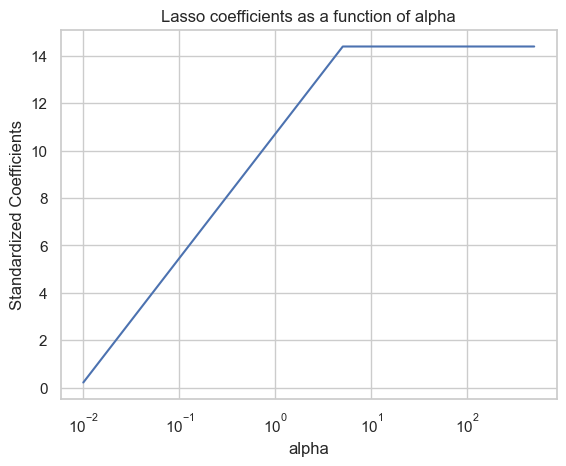

In [8]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []
test_mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    test_mse.append(mean_squared_error(lasso.predict(X_test), y_test))

ax = plt.gca()

ax.plot(alphas, test_mse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

<p>Next, we use cross-validation to find the best value for alpha.</p>

<h5 style="color: teal">Optimal Alpha using K-Folds cross validation</h5>

In [16]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [17]:
model.alpha_

0.0030874837788565004

<h4 style="color: #ccdd55">Running with best Alpha value</h4>

In [18]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.0030874837788565004)

In [19]:
print(list(zip(lasso_best.coef_, X)))

[(-0.04373767670936338, '883.108'), (-0.01706755489249504, '889.669'), (0.0, '896.213'), (-0.014303718756130145, '902.739'), (-0.290823853246297, '909.247'), (0.02553801230561071, '915.738'), (-0.09372853134306589, '922.211'), (-0.06010560804922833, '928.667'), (-0.052890061581905304, '935.106'), (-0.004115105634558271, '941.528'), (-0.08171080000042732, '947.932'), (-0.0901520138214878, '954.32'), (-0.048398739242934655, '960.69'), (-0.15620817746128354, '967.044'), (-0.0, '973.382'), (-0.02648439252057812, '979.702'), (-0.017702593932568504, '986.007'), (-0.0, '992.294'), (-0.04730298571616819, '998.566'), (-0.10858393453488485, '1004.821'), (-0.08499574643122983, '1011.061'), (-0.08366437071525026, '1017.284'), (-0.23853200900455482, '1023.491'), (-0.08548794993824191, '1029.683'), (-0.08370579483856297, '1035.859'), (-0.0, '1042.019'), (-0.05668606215004773, '1048.163'), (-0.03452705865334785, '1054.293'), (-0.045757865499419494, '1060.406'), (-0.07504545955550718, '1066.505'), (-0

<h4 style="color: #11cc44">Model Evaluation</h4>

In [20]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 99.1
R squared test set 98.6


In [21]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.2002010138107063

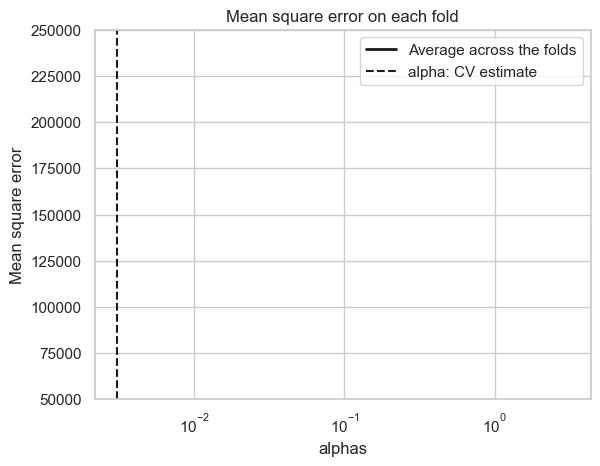

In [22]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);